# Import Modules

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from numpy import asarray
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report

# %tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import * 
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow import keras

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import callbacks

def VisRes(res):
    plt.plot(list(res.history.values())[0],'b',label='Train-Loss')
    plt.plot(list(res.history.values())[1],'orange',label='Train-Accuracy')
    plt.plot(list(res.history.values())[2],'g',label='Valid-Loss')
    plt.plot(list(res.history.values())[3],'y',label='Valid-Accuracy')
    plt.legend(loc='best', shadow=True)

np.random.seed(1)
from tensorflow.random import set_seed
set_seed(2)

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14299477757224953980
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11611125161293355701
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16484971121572808350
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15695549568
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3826427791342200129
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


# Import Data 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/PY/SemEval2021

/content/drive/My Drive/PY/SemEval2021


# EDA

In [ ]:
data = pd.read_csv("train.csv")
data

,id,text,is_humor,humor_rating,humor_controversy,offense_rating
0,1,TENNESSEE: We're the best state. Nobody even c...,1,2.42,1.0,0.20
1,2,A man inserted an advertisement in the classif...,1,2.50,1.0,1.10
2,3,How many men does it take to open a can of bee...,1,1.95,0.0,2.40
3,4,Told my mom I hit 1200 Twitter followers. She ...,1,2.11,1.0,0.00
4,5,Roses are dead. Love is fake. Weddings are bas...,1,2.78,0.0,0.10
...,...,...,...,...,...,...
7995,7996,Lack of awareness of the pervasiveness of raci...,0,NaN,NaN,0.25
7996,7997,Why are aspirins white? Because they work sorry,1,1.33,0.0,3.85
7997,7998,"Today, we Americans celebrate our independence...",1,2.55,0.0,0.00
7998,7999,How to keep the flies off the bride at an Ital...,1,1.00,0.0,3.00


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 8000 non-null   int64  
 1   text               8000 non-null   object 
 2   is_humor           8000 non-null   int64  
 3   humor_rating       4932 non-null   float64
 4   humor_controversy  4932 non-null   float64
 5   offense_rating     8000 non-null   float64
dtypes: float64(3), int64(2), object(1)
memory usage: 375.1+ KB


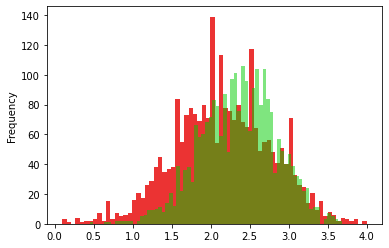

In [ ]:
# Controversy / humor rating distribution
data[data.humor_controversy==0].humor_rating.sort_values(ascending=False).plot.hist(bins=70,fc=(0.9, 0, 0, 0.8))
data[data.humor_controversy==1].humor_rating.sort_values(ascending=False).plot.hist(bins=70,fc=(0, 0.8, 0, 0.5))

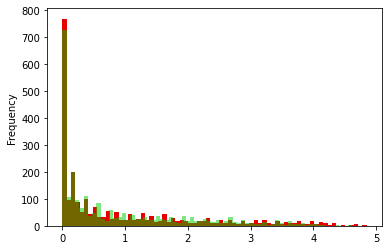

In [ ]:
# Controversy / offense rating distribution
data[data.humor_controversy==0].offense_rating.sort_values(ascending=False).plot.hist(bins=70,fc=(0.9, 0, 0, 1))
data[data.humor_controversy==1].offense_rating.sort_values(ascending=False).plot.hist(bins=70,fc=(0, 0.8, 0, 0.5))


In [ ]:
data.is_humor.value_counts()

1    4932
0    3068
Name: is_humor, dtype: int64

In [ ]:
data.iloc[:,[3,5]].describe()

,humor_rating,offense_rating
count,4932.000000,8000.000000
mean,2.260525,0.585325
std,0.566974,0.979955
min,0.100000,0.000000
25%,1.890000,0.000000
50%,2.280000,0.100000
75%,2.650000,0.700000
max,4.000000,4.850000


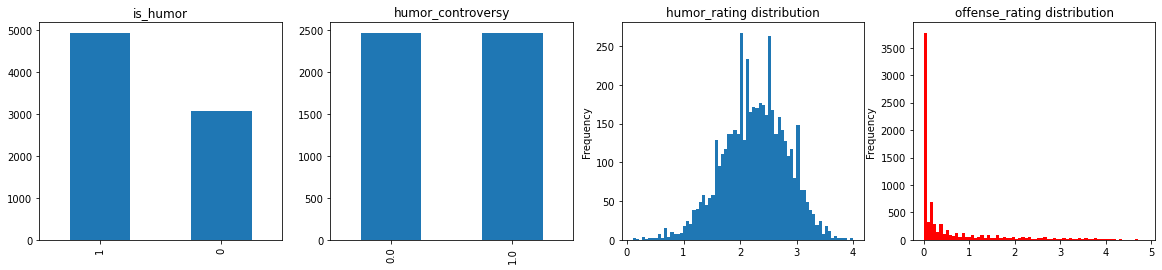

In [ ]:
f=plt.figure(figsize=(20,4))
f.patch.set_facecolor('xkcd:white')
plt.subplot('141')
data.is_humor.value_counts().plot.bar(title='is_humor')
plt.subplot('142')
data.humor_controversy.value_counts().plot.bar(title='humor_controversy')
plt.subplot('143')
data.humor_rating.plot.hist(title='humor_rating distribution', bins=70) # 0-5
plt.subplot('144')
data.offense_rating.plot.hist(title='offense_rating distribution',color='r', bins=70) # 0-5
plt.show()

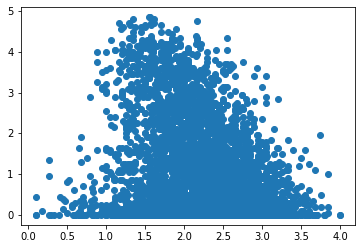

In [ ]:
plt.scatter(data.humor_rating,data.offense_rating)

# Prepare Data

In [ ]:
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords,wordnet
# from nltk.stem import PorterStemmer,WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
stopwordEn = stopwords.words('english')
def lemmaWord(word):
    lemma = wordnet.morphy(word) 
    # lemmar = WordNetLemmatizer()
    # lemma = lemmar.lemmatize(word) 
    if lemma is not None:
        return lemma
    else:
        return word
def processText(text,lemma=False, gram=1, rmStop=True): # default remove stop words
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b|@\w+|#', '', text, flags=re.MULTILINE) #delete URL, #hashtag# , and @xxx
    tokens = word_tokenize(text)
    whitelist = ["n't", "not", "no"]
    new_tokens = []
    stoplist = stopwordEn if rmStop else []
    for i in tokens:
      i = i.lower()
      if i not in ['.',',',';'] and (i not in stoplist or i in whitelist):  #i.isalpha() and (...)
        if lemma: i = lemmaWord(i)
        new_tokens.append(i)
    del tokens
    # tokens = [lemmaWord(i.lower()) if lemma else i.lower() for i in tokens if (i.lower() not in stoplist or i.lower() in whitelist) and i.isalpha()]
    if gram<=1:
        return new_tokens
    else:
        return [' '.join(i) for i in nltk.ngrams(new_tokens, gram)]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
print(processText(data.text[100],rmStop=False))


['last', 'night', 'my', 'wife', 'and', 'i', 'watched', '2', 'hours', 'of', 'cooking', 'shows', 'before', 'she', 'hugged', 'me', 'and', 'went', 'to', 'bed', 'i', "'m", 'pretty', 'sure', 'i', "'m", 'in', 'the', 'friend', 'zone']


In [ ]:
print(processText(data.text[100],rmStop=True))


['last', 'night', 'wife', 'watched', '2', 'hours', 'cooking', 'shows', 'hugged', 'went', 'bed', "'m", 'pretty', 'sure', "'m", 'friend', 'zone']


In [ ]:
data.text[100]

"Last night my wife and I watched 2 hours of cooking shows, before she hugged me and went to bed. I'm pretty sure I'm in the friend zone."

In [ ]:
data.loc[:,'tokens'] = [processText(t, rmStop=True) for t in data.text]
data.loc[:,'token_len'] = [len(t) for t in data.tokens]
data['humor_rating'] = data['humor_rating'].fillna(0)
data.head()

,id,text,is_humor,humor_rating,humor_controversy,offense_rating,tokens,token_len
0,1,TENNESSEE: We're the best state. Nobody even c...,1,2.42,1.0,0.2,"[tennessee, :, 're, best, state, nobody, even,...",17
1,2,A man inserted an advertisement in the classif...,1,2.50,1.0,1.1,"[man, inserted, advertisement, classifieds, ``...",24
2,3,How many men does it take to open a can of bee...,1,1.95,0.0,2.4,"[many, men, take, open, beer, ?, none, open, t...",11
3,4,Told my mom I hit 1200 Twitter followers. She ...,1,2.11,1.0,0.0,"[told, mom, hit, 1200, twitter, followers, poi...",17
4,5,Roses are dead. Love is fake. Weddings are bas...,1,2.78,0.0,0.1,"[roses, dead, love, fake, weddings, basically,...",8


In [ ]:
# with open('train_tokens.pickle', 'wb') as handle:
#     pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('train_tokens.pickle', 'rb') as handle:
    data = pickle.load(handle)

In [ ]:
dist_0 = nltk.FreqDist([t for s in data[data.is_humor==0].tokens for t in s])
dist_1 = nltk.FreqDist([t for s in data[data.is_humor==1].tokens for t in s])

# Tokenization


In [ ]:
# Word Embedding
np.random.seed(1)
set_seed(2)
t = Tokenizer()
t.fit_on_texts([' '.join(i) for i in data['tokens']])

def encodeText(orig_tokens,max_len=0):  
  vocab_size = len(t.word_index) + 1
  encoded_train = t.texts_to_sequences([' '.join(i) for i in orig_tokens])
  max_length = max(list(map(lambda x: len(x), encoded_train))) if max_len==0 else max_len
  padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')
  return padded_train, vocab_size, max_length

In [ ]:
X, vocab_size, max_length = encodeText(data['tokens'])
X.shape, vocab_size, max_length #((8000, 68), 14766, 68)

((8000, 68), 14766, 68)

In [ ]:
Y = to_categorical(data['is_humor'])

## Pre-Trained GloVe Embedding

In [ ]:
# load the whole embedding into memory
EMB_DIM = 50
embeddings_dict = {}
with open(F"./GLOVE/glove.twitter.27B.{EMB_DIM}d.txt", 'rb') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        if len(vector)==EMB_DIM:
            embeddings_dict[word] = vector
print('Loaded %s word vectors.' % len(embeddings_dict))

Loaded 1193514 word vectors.


In [ ]:
emb_matrix = np.zeros((vocab_size, EMB_DIM))

for w, i in t.word_index.items():
    # The word_index contains a token for all words of the training data so we need to limit that
    if i < vocab_size:
        vect = embeddings_dict.get(bytes(w, 'utf-8'))
        # Check if the word from the training data occurs in the GloVe word embeddings
        # Otherwise the vector is kept with only zeros
        if vect is not None:
            emb_matrix[i] = vect
    else:
        break
emb_matrix.shape

(14766, 50)

In [ ]:
X.shape

(8000, 68)

In [ ]:
X[:1]

array([[2376,   12,   60,  430,  540,   70,  170,  445, 7552,  337,  237,
        2376,  159,  295,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0]], dtype=int32)

In [ ]:
t.index_word[2376]

'tennessee'

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
count_vect = CountVectorizer(analyzer='word', ngram_range=(1, 1))
X_train_counts = count_vect.fit_transform([' '.join(t) for t in data['tokens']])
X_train_counts.shape

(8000, 14426)

In [ ]:
count_vect.vocabulary_.get('tennessee'),count_vect.get_feature_names()[500]

(12821, 'adjust')

In [ ]:
X_train_counts.toarray() # each number is a word occurrence value

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
pd.Series(X_train_counts.toarray()[0]).value_counts()

0    14413
1       12
2        1
dtype: int64

In [ ]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_counts)
X_train_tfidf = tf_transformer.transform(X_train_counts)
X_train_tfidf.toarray().shape

(8000, 14426)

In [ ]:
pd.Series(X_train_tfidf.toarray()[0]).value_counts()

0.000000    14413
0.210898        1
0.232810        1
0.226196        1
0.145770        1
0.185936        1
0.608252        1
0.208944        1
0.240865        1
0.242007        1
0.344894        1
0.183461        1
0.223284        1
0.248312        1
dtype: int64

In [ ]:
docs_seq = t.texts_to_sequences([' '.join(t) for t in data['tokens']])  #根据word_index字典把对应的word转换为index
docs_seq_dev = t.texts_to_sequences([' '.join(t) for t in dev['tokens']])
np.array(docs_seq).shape

(8000,)

In [ ]:
def one_hot_seq(seqs, nb_features = vocab_size):
    ohs = np.zeros((len(seqs), nb_features))
    for i, s in enumerate(seqs):
        ohs[i, s] = 1.
    return ohs
# Size = rows * vocab size
docs_oh = one_hot_seq(docs_seq) # binary vec
docs_oh_dev = one_hot_seq(docs_seq_dev)

docs_oh.shape

(8000, 14766)

# Modelling

## Linear Models


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
text_clf = Pipeline([
    ('vect', CountVectorizer(analyzer='word', ngram_range=(1, 1))),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', SGDClassifier(random_state=42,n_jobs=-1)),
])
text_clf = text_clf.fit([' '.join(t) for t in data['tokens']], data['is_humor'])
predicted = text_clf.predict([' '.join(t) for t in dev['tokens']])
pd.Series(predicted).value_counts()

1    696
0    304
dtype: int64

In [ ]:
output = pd.DataFrame(dev.loc[:,'id'])
output.loc[:,'is_humor'] = predicted
compression_opts = dict(method='zip', archive_name='res.csv')  
output.to_csv('zehao_liu_dev20_linearSVC_1.zip', index=None, compression=compression_opts)

## FC


Epoch 1/20
100/100 [==============================] - 0s 5ms/step - loss: 0.9505 - accuracy: 0.6194 - val_loss: 0.8718 - val_accuracy: 0.6056
Epoch 2/20
100/100 [==============================] - 0s 4ms/step - loss: 0.8170 - accuracy: 0.6192 - val_loss: 0.7788 - val_accuracy: 0.6056
Epoch 3/20
100/100 [==============================] - 0s 4ms/step - loss: 0.7420 - accuracy: 0.6192 - val_loss: 0.7209 - val_accuracy: 0.6056
Epoch 4/20
100/100 [==============================] - 0s 4ms/step - loss: 0.6980 - accuracy: 0.6192 - val_loss: 0.6904 - val_accuracy: 0.6056
Epoch 5/20
100/100 [==============================] - 0s 4ms/step - loss: 0.6771 - accuracy: 0.6192 - val_loss: 0.6768 - val_accuracy: 0.6056
Epoch 6/20
100/100 [==============================] - 0s 4ms/step - loss: 0.6688 - accuracy: 0.6192 - val_loss: 0.6732 - val_accuracy: 0.6056
Epoch 7/20
100/100 [==============================] - 0s 4ms/step - loss: 0.6672 - accuracy: 0.6192 - val_loss: 0.6725 - val_accuracy: 0.6056
Epoch 

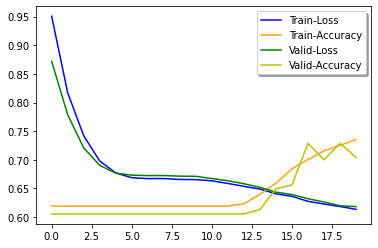

In [ ]:
# fc - tfidf
np.random.seed(1)
set_seed(2)
model = Sequential()
model.add(Dense(16, input_shape=(14426,), activation='relu', kernel_regularizer=regularizers.l2(0.01),kernel_initializer='he_uniform'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01),kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='sigmoid'))

model.compile(loss = "binary_crossentropy", 
             optimizer = 'rmsprop',
             metrics = ['accuracy'])
results_fc= model.fit(X_train_tfidf.toarray(), Y, epochs=20, shuffle=True, validation_split=0.2, batch_size=64)
VisRes(results_fc)


Epoch 1/20
100/100 [==============================] - 1s 5ms/step - loss: 0.9383 - accuracy: 0.6187 - val_loss: 0.8417 - val_accuracy: 0.6056
Epoch 2/20
100/100 [==============================] - 0s 4ms/step - loss: 0.7792 - accuracy: 0.6231 - val_loss: 0.7240 - val_accuracy: 0.6106
Epoch 3/20
100/100 [==============================] - 0s 4ms/step - loss: 0.6848 - accuracy: 0.6747 - val_loss: 0.6451 - val_accuracy: 0.7219
Epoch 4/20
100/100 [==============================] - 0s 4ms/step - loss: 0.6245 - accuracy: 0.7369 - val_loss: 0.5990 - val_accuracy: 0.7531
Epoch 5/20
100/100 [==============================] - 0s 4ms/step - loss: 0.5919 - accuracy: 0.7634 - val_loss: 0.5678 - val_accuracy: 0.7962
Epoch 6/20
100/100 [==============================] - 0s 4ms/step - loss: 0.5653 - accuracy: 0.7909 - val_loss: 0.5489 - val_accuracy: 0.8106
Epoch 7/20
100/100 [==============================] - 0s 4ms/step - loss: 0.5511 - accuracy: 0.7914 - val_loss: 0.5365 - val_accuracy: 0.8100
Epoch 

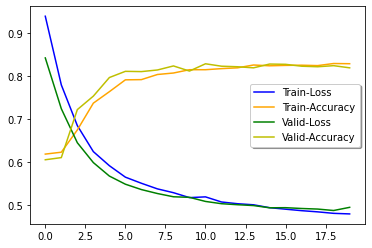

In [ ]:
# fc - docs-oh
np.random.seed(1)
set_seed(2)
model = Sequential()
model.add(Dense(16, input_shape=(vocab_size,), activation='relu', kernel_regularizer=regularizers.l2(0.01),kernel_initializer='he_uniform'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01),kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='sigmoid'))

model.compile(loss = "binary_crossentropy", 
             optimizer = 'rmsprop',
             metrics = ['accuracy'])
results_fc= model.fit(docs_oh, Y, epochs=20, shuffle=True, validation_split=0.2, batch_size=64)
VisRes(results_fc)

Epoch 1/30
100/100 [==============================] - 0s 3ms/step - loss: 647.1820 - accuracy: 0.5567 - val_loss: 157.6167 - val_accuracy: 0.5594
Epoch 2/30
100/100 [==============================] - 0s 2ms/step - loss: 197.6285 - accuracy: 0.5414 - val_loss: 58.0259 - val_accuracy: 0.5387
Epoch 3/30
100/100 [==============================] - 0s 2ms/step - loss: 67.6047 - accuracy: 0.5345 - val_loss: 22.2695 - val_accuracy: 0.5500
Epoch 4/30
100/100 [==============================] - 0s 2ms/step - loss: 21.6105 - accuracy: 0.5859 - val_loss: 8.5602 - val_accuracy: 0.5794
Epoch 5/30
100/100 [==============================] - 0s 2ms/step - loss: 8.2254 - accuracy: 0.5980 - val_loss: 3.7386 - val_accuracy: 0.5831
Epoch 6/30
100/100 [==============================] - 0s 2ms/step - loss: 3.4749 - accuracy: 0.6052 - val_loss: 2.1838 - val_accuracy: 0.5881
Epoch 7/30
100/100 [==============================] - 0s 2ms/step - loss: 1.8496 - accuracy: 0.6098 - val_loss: 1.4927 - val_accuracy: 0.5

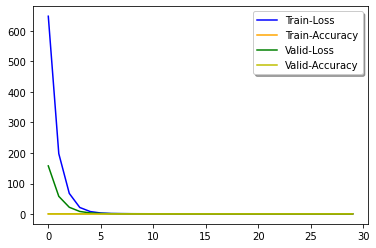

In [ ]:
# fc - x
np.random.seed(1)
set_seed(2)
model = Sequential()
model.add(Dense(16, input_shape=(68,), activation='relu', kernel_regularizer=regularizers.l2(0.01),kernel_initializer='he_uniform'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01),kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='sigmoid'))

model.compile(loss = "binary_crossentropy", 
             optimizer = 'rmsprop',
             metrics = ['accuracy'])
results_fc= model.fit(X, Y, epochs=30, shuffle=True, validation_split=0.2, batch_size=64)
VisRes(results_fc)

Epoch 1/30
100/100 [==============================] - 1s 7ms/step - loss: 0.9322 - accuracy: 0.6147 - val_loss: 0.8484 - val_accuracy: 0.6056
Epoch 2/30
100/100 [==============================] - 1s 6ms/step - loss: 0.7644 - accuracy: 0.6341 - val_loss: 0.6884 - val_accuracy: 0.6062
Epoch 3/30
100/100 [==============================] - 1s 6ms/step - loss: 0.6105 - accuracy: 0.7178 - val_loss: 0.5786 - val_accuracy: 0.7844
Epoch 4/30
100/100 [==============================] - 1s 6ms/step - loss: 0.4977 - accuracy: 0.8594 - val_loss: 0.5138 - val_accuracy: 0.8300
Epoch 5/30
100/100 [==============================] - 1s 6ms/step - loss: 0.4155 - accuracy: 0.9153 - val_loss: 0.4795 - val_accuracy: 0.8356
Epoch 6/30
100/100 [==============================] - 1s 6ms/step - loss: 0.3574 - accuracy: 0.9328 - val_loss: 0.4590 - val_accuracy: 0.8400
Epoch 7/30
100/100 [==============================] - 1s 6ms/step - loss: 0.3024 - accuracy: 0.9486 - val_loss: 0.4541 - val_accuracy: 0.8331
Epoch 

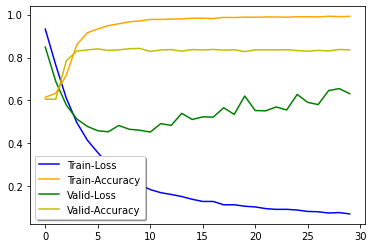

In [ ]:
# fc - x + Embedding
np.random.seed(1)
set_seed(2)
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_length))
model.add(Flatten())

model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01),kernel_initializer='he_uniform'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01),kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='sigmoid'))

model.compile(loss = "binary_crossentropy", 
             optimizer = 'rmsprop',
             metrics = ['accuracy'])
results_fc= model.fit(X, Y, epochs=30, shuffle=True, validation_split=0.2, batch_size=64)
VisRes(results_fc)

## LSTM 

In [ ]:
np.random.seed(1)
set_seed(2)
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_length))
model.add(Dropout(0.5))
model.add(LSTM(32, return_sequences=True, kernel_regularizer=regularizers.l2(0.001),kernel_initializer='he_uniform')) # defaultly use tanh for cuDNNLSTM
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(16, activation='relu')) 
model.add(Dropout(0.1))

model.add(Dense(2, activation='sigmoid'))

model.compile(loss = "binary_crossentropy", 
             optimizer = 'rmsprop',
             metrics = ['accuracy'
            #  ,keras.metrics.Precision(name='precision'),
                  # keras.metrics.Recall(name='recall')
                  ])
model.summary()


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 68, 100)           1476600   
_________________________________________________________________
dropout_25 (Dropout)         (None, 68, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 68, 32)            17024     
_________________________________________________________________
dropout_26 (Dropout)         (None, 68, 32)            0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 2176)              0         
_________________________________________________________________
dense_35 (Dense)             (None, 16)                34832     
_________________________________________________________________
dropout_27 (Dropout)         (None, 16)              

Epoch 1/23
100/100 [==============================] - 1s 13ms/step - loss: 0.3855 - accuracy: 0.8697 - val_loss: 0.4244 - val_accuracy: 0.8425
Epoch 2/23
100/100 [==============================] - 1s 10ms/step - loss: 0.2795 - accuracy: 0.9087 - val_loss: 0.4354 - val_accuracy: 0.8475
Epoch 3/23
100/100 [==============================] - 1s 10ms/step - loss: 0.2329 - accuracy: 0.9266 - val_loss: 0.4240 - val_accuracy: 0.8425
Epoch 4/23
100/100 [==============================] - 1s 10ms/step - loss: 0.1995 - accuracy: 0.9378 - val_loss: 0.4522 - val_accuracy: 0.8406
Epoch 5/23
100/100 [==============================] - 1s 10ms/step - loss: 0.1685 - accuracy: 0.9511 - val_loss: 0.4042 - val_accuracy: 0.8400
Epoch 6/23
100/100 [==============================] - 1s 10ms/step - loss: 0.1513 - accuracy: 0.9561 - val_loss: 0.4544 - val_accuracy: 0.8350
Epoch 7/23
100/100 [==============================] - 1s 10ms/step - loss: 0.1354 - accuracy: 0.9613 - val_loss: 0.5341 - val_accuracy: 0.8306

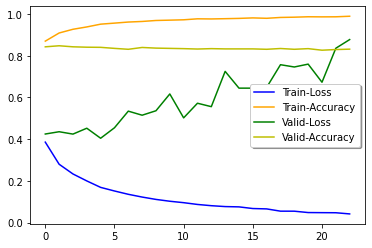

In [ ]:
results_lstm = model.fit(X, Y, epochs=23, shuffle=True, validation_split=0.2, batch_size=64)
VisRes(results_lstm)

Epoch 1/23
100/100 [==============================] - 2s 18ms/step - loss: 0.5087 - accuracy: 0.7450 - val_loss: 0.3951 - val_accuracy: 0.8200
Epoch 2/23
100/100 [==============================] - 1s 15ms/step - loss: 0.4161 - accuracy: 0.8172 - val_loss: 0.3384 - val_accuracy: 0.8500
Epoch 3/23
100/100 [==============================] - 1s 14ms/step - loss: 0.3779 - accuracy: 0.8356 - val_loss: 0.3228 - val_accuracy: 0.8650
Epoch 4/23
100/100 [==============================] - 1s 15ms/step - loss: 0.3505 - accuracy: 0.8445 - val_loss: 0.2977 - val_accuracy: 0.8781
Epoch 5/23
100/100 [==============================] - 1s 15ms/step - loss: 0.3293 - accuracy: 0.8597 - val_loss: 0.2914 - val_accuracy: 0.8850
Epoch 6/23
100/100 [==============================] - 1s 14ms/step - loss: 0.3153 - accuracy: 0.8658 - val_loss: 0.2861 - val_accuracy: 0.8838
Epoch 7/23
100/100 [==============================] - 1s 14ms/step - loss: 0.2964 - accuracy: 0.8733 - val_loss: 0.2841 - val_accuracy: 0.8869

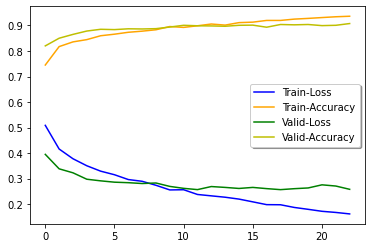

In [ ]:
# Glove + LSTM quick 
np.random.seed(1)
set_seed(2)
model = Sequential()
model.add(Embedding(vocab_size, EMB_DIM, input_length=max_length, weights=[emb_matrix], trainable=True))
model.add(Dropout(0.5))
model.add(LSTM(32, return_sequences=True, kernel_regularizer=regularizers.l2(0.001),kernel_initializer='he_uniform')) # defaultly use tanh for cuDNNLSTM
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(16, activation='relu')) # 这层加l2最差，给output加第二，不加两个最好
model.add(Dropout(0.1))

model.add(Dense(2, activation='sigmoid'))

# opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-6)
model.compile(loss = "binary_crossentropy", 
             optimizer = 'rmsprop',
             metrics = ['accuracy'])
results_lstm_glove = model.fit(X, Y, epochs=23, shuffle=True, validation_split=0.2, batch_size=64)
VisRes(results_lstm_glove)

Epoch 1/23
100/100 [==============================] - 2s 18ms/step - loss: 1.0105 - accuracy: 0.6187 - val_loss: 0.8897 - val_accuracy: 0.6056
Epoch 2/23
100/100 [==============================] - 1s 12ms/step - loss: 0.7881 - accuracy: 0.6439 - val_loss: 0.6589 - val_accuracy: 0.7088
Epoch 3/23
100/100 [==============================] - 1s 12ms/step - loss: 0.5918 - accuracy: 0.7561 - val_loss: 0.6097 - val_accuracy: 0.7494
Epoch 4/23
100/100 [==============================] - 1s 12ms/step - loss: 0.5193 - accuracy: 0.7875 - val_loss: 0.4806 - val_accuracy: 0.7900
Epoch 5/23
100/100 [==============================] - 1s 12ms/step - loss: 0.4836 - accuracy: 0.8078 - val_loss: 0.4327 - val_accuracy: 0.8275
Epoch 6/23
100/100 [==============================] - 1s 11ms/step - loss: 0.4607 - accuracy: 0.8189 - val_loss: 0.4231 - val_accuracy: 0.8138
Epoch 7/23
100/100 [==============================] - 1s 11ms/step - loss: 0.4248 - accuracy: 0.8348 - val_loss: 0.3952 - val_accuracy: 0.8413

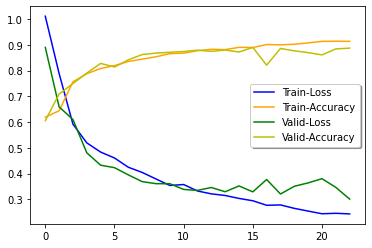

In [ ]:
# Glove + LSTM * 2 quick & best 
np.random.seed(1)
set_seed(2)
model = Sequential()
model.add(Embedding(vocab_size, EMB_DIM, input_length=max_length, weights=[emb_matrix], trainable=True))
model.add(Dropout(0.5))
model.add(LSTM(32, return_sequences=True, kernel_regularizer=regularizers.l2(0.001),kernel_initializer='he_uniform')) # defaultly use tanh for cuDNNLSTM
model.add(Dropout(0.2))
model.add(LSTM(32, kernel_regularizer=regularizers.l2(0.001),kernel_initializer='he_uniform')) # defaultly use tanh for cuDNNLSTM
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(2, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001),kernel_initializer='he_uniform'))

# opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-6)
model.compile(loss = "binary_crossentropy", 
             optimizer = 'rmsprop',
             metrics = ['accuracy'])
results_lstm_glove = model.fit(X, Y, epochs=23, shuffle=True, validation_split=0.2, batch_size=64)
VisRes(results_lstm_glove)

In [ ]:
model.save('./models/lstm_g50-lstm32lstm32g-fc16-23epo-0.3011_625.h5')

In [ ]:
res = pd.read_csv('res_0.844.csv')
res

,id,is_humor
0,8001,1
1,8002,1
2,8003,1
3,8004,1
4,8005,1
...,...,...
995,8996,1
996,8997,0
997,8998,1
998,8999,1


### Task 1b

In [ ]:
def minMaxScaler(X,min=0.1,max=1):
  X = X.astype("float")
  X_std = (X - X.min()) / (X.max() - X.min())
  X_scaled = X_std * (max - min) + min
  return X_scaled

In [ ]:
# data['humor_rating'] = data['humor_rating'].replace(0.00,-1.00)
# data['humor_rating'] = data['humor_rating']/4
data['humor_rating'] = minMaxScaler(data['humor_rating'])

(array([  3.,   0.,   1.,   0.,   3.,   2.,   0.,   2.,   2.,   1.,   2.,
          3.,   5.,   2.,   8.,  10.,   2.,   5.,  10.,   2.,   6.,  10.,
          0.,  18.,  15.,  17.,  13.,  17.,  30.,  31.,  34.,  27.,  46.,
         42.,  35.,  63.,  17.,  77.,  67.,  80.,  52.,  78.,  98., 127.,
        120.,  73.,  96., 137., 156.,   0., 162., 160., 151., 117.,  80.,
        159., 150., 121., 173.,  57., 161., 125., 138.,  58., 161., 107.,
        137., 136.,  58.,  76., 102., 104.,  19.,  80.,  81.,  79.,  52.,
         21.,  49.,  43.,  29.,  14.,  29.,  19.,  19.,  10.,   3.,  13.,
          6.,  10.,   0.,   6.,   2.,   3.,   2.,   1.,   2.,   0.,   0.,
          2.]),
 array([0.1225  , 0.131275, 0.14005 , 0.148825, 0.1576  , 0.166375,
        0.17515 , 0.183925, 0.1927  , 0.201475, 0.21025 , 0.219025,
        0.2278  , 0.236575, 0.24535 , 0.254125, 0.2629  , 0.271675,
        0.28045 , 0.289225, 0.298   , 0.306775, 0.31555 , 0.324325,
        0.3331  , 0.341875, 0.35065 , 0.359425

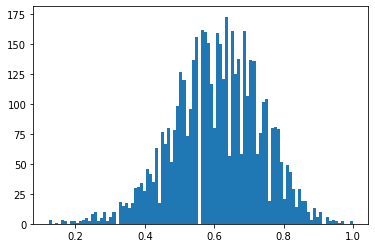

In [ ]:
plt.hist(data[data.is_humor==1]['humor_rating'],bins=100)

Epoch 1/23
62/62 [==============================] - 1s 19ms/step - loss: 0.2165 - cosine_similarity: 1.0000 - val_loss: 0.1590 - val_cosine_similarity: 1.0000
Epoch 2/23
62/62 [==============================] - 1s 11ms/step - loss: 0.1204 - cosine_similarity: 1.0000 - val_loss: 0.0898 - val_cosine_similarity: 1.0000
Epoch 3/23
62/62 [==============================] - 1s 11ms/step - loss: 0.0651 - cosine_similarity: 1.0000 - val_loss: 0.0489 - val_cosine_similarity: 1.0000
Epoch 4/23
62/62 [==============================] - 1s 12ms/step - loss: 0.0352 - cosine_similarity: 1.0000 - val_loss: 0.0275 - val_cosine_similarity: 1.0000
Epoch 5/23
62/62 [==============================] - 1s 12ms/step - loss: 0.0219 - cosine_similarity: 1.0000 - val_loss: 0.0200 - val_cosine_similarity: 1.0000
Epoch 6/23
62/62 [==============================] - 1s 11ms/step - loss: 0.0176 - cosine_similarity: 1.0000 - val_loss: 0.0182 - val_cosine_similarity: 1.0000
Epoch 7/23
62/62 [============================

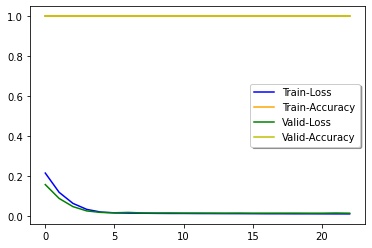

In [ ]:
# humor ration Regression
# Glove + LSTM quick & best
np.random.seed(1)
set_seed(2)
def regModel_1b():
  model = Sequential()
  model.add(Embedding(vocab_size, EMB_DIM, input_length=max_length, weights=[emb_matrix], trainable=True))
  model.add(Dropout(0.5))
  model.add(LSTM(32, return_sequences=True,kernel_regularizer=regularizers.l2(0.001),kernel_initializer='he_uniform')) # defaultly use tanh for cuDNNLSTM
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer='he_uniform'))
  model.add(Dropout(0.1))

  model.add(Dense(1, activation='sigmoid'))
  return model
model_1b = regModel_1b()
# opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-6)
model_1b.compile(loss = "mse", 
             optimizer = 'rmsprop',
             metrics = ['cosine_similarity'])
results_lstm_glove_1b = model_1b.fit(X[data.is_humor==1], data[data.is_humor==1]['humor_rating'], epochs=23, shuffle=True, validation_split=0.2, batch_size=64)
VisRes(results_lstm_glove_1b)

### Task 1c

Epoch 1/15
62/62 [==============================] - 1s 21ms/step - loss: 1.4494 - accuracy: 0.4882 - val_loss: 1.2383 - val_accuracy: 0.5117
Epoch 2/15
62/62 [==============================] - 1s 13ms/step - loss: 1.0915 - accuracy: 0.5014 - val_loss: 0.9623 - val_accuracy: 0.4914
Epoch 3/15
62/62 [==============================] - 1s 13ms/step - loss: 0.8801 - accuracy: 0.5022 - val_loss: 0.8248 - val_accuracy: 0.4894
Epoch 4/15
62/62 [==============================] - 1s 13ms/step - loss: 0.7659 - accuracy: 0.5087 - val_loss: 0.7311 - val_accuracy: 0.4934
Epoch 5/15
62/62 [==============================] - 1s 12ms/step - loss: 0.7172 - accuracy: 0.5199 - val_loss: 0.7170 - val_accuracy: 0.4924
Epoch 6/15
62/62 [==============================] - 1s 12ms/step - loss: 0.7018 - accuracy: 0.5412 - val_loss: 0.7001 - val_accuracy: 0.5117
Epoch 7/15
62/62 [==============================] - 1s 13ms/step - loss: 0.6939 - accuracy: 0.5597 - val_loss: 0.6983 - val_accuracy: 0.5228
Epoch 8/15
62

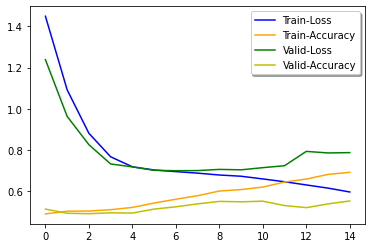

In [ ]:
# Glove + LSTM quick & best - 1c
np.random.seed(1)
set_seed(2)
def model_1c():
  model = Sequential()
  model.add(Embedding(vocab_size, EMB_DIM, input_length=max_length, weights=[emb_matrix], trainable=True))
  model.add(Dropout(0.3))
  model.add(LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.001),kernel_initializer='he_uniform')) # defaultly use tanh for cuDNNLSTM
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(16, activation='relu'))
  model.add(Dropout(0.1))

  model.add(Dense(2, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001),kernel_initializer='he_uniform'))
  return model
model_1c = model_1c()
# opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-6)
model_1c.compile(loss = "binary_crossentropy", 
             optimizer = 'rmsprop',
             metrics = ['accuracy'])
results_lstm_glove = model_1c.fit(X[data.is_humor==1], to_categorical(data[data.is_humor==1]['humor_controversy']), epochs=15, shuffle=True, validation_split=0.2, batch_size=64)
VisRes(results_lstm_glove)

In [ ]:
data[data.is_humor==1].iloc[:,[2,3,4,5]]

,is_humor,humor_rating,humor_controversy,offense_rating
0,1,0.6050,1.0,0.20
1,1,0.6250,1.0,1.10
2,1,0.4875,0.0,2.40
3,1,0.5275,1.0,0.00
4,1,0.6950,0.0,0.10
...,...,...,...,...
7991,1,0.5325,1.0,0.10
7993,1,0.9250,0.0,0.00
7996,1,0.3325,0.0,3.85
7997,1,0.6375,0.0,0.00


In [ ]:
clf = SGDClassifier(random_state=42,n_jobs=-1)
clf.fit(data[data.is_humor==1].iloc[:,[2]],data[data.is_humor==1]['humor_controversy'])

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

### Task 2

Epoch 1/23
100/100 [==============================] - 2s 15ms/step - loss: 0.2083 - cosine_similarity: 1.0000 - val_loss: 0.1317 - val_cosine_similarity: 1.0000
Epoch 2/23
100/100 [==============================] - 1s 10ms/step - loss: 0.0929 - cosine_similarity: 1.0000 - val_loss: 0.0607 - val_cosine_similarity: 1.0000
Epoch 3/23
100/100 [==============================] - 1s 10ms/step - loss: 0.0491 - cosine_similarity: 1.0000 - val_loss: 0.0374 - val_cosine_similarity: 1.0000
Epoch 4/23
100/100 [==============================] - 1s 10ms/step - loss: 0.0355 - cosine_similarity: 1.0000 - val_loss: 0.0298 - val_cosine_similarity: 1.0000
Epoch 5/23
100/100 [==============================] - 1s 10ms/step - loss: 0.0309 - cosine_similarity: 1.0000 - val_loss: 0.0279 - val_cosine_similarity: 1.0000
Epoch 6/23
100/100 [==============================] - 1s 10ms/step - loss: 0.0284 - cosine_similarity: 1.0000 - val_loss: 0.0294 - val_cosine_similarity: 1.0000
Epoch 7/23
100/100 [==============

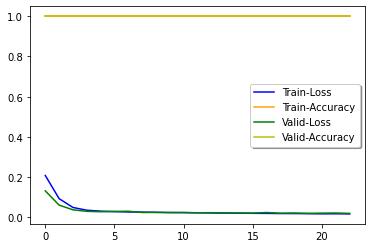

In [ ]:
# humor ration Regression -2c
# Glove + LSTM quick & best
np.random.seed(1)
set_seed(2)
def regModel_2():
  model = Sequential()
  model.add(Embedding(vocab_size, EMB_DIM, input_length=max_length, weights=[emb_matrix], trainable=True))
  model.add(Dropout(0.5))
  model.add(LSTM(32, return_sequences=True,kernel_regularizer=regularizers.l2(0.001),kernel_initializer='he_uniform')) # defaultly use tanh for cuDNNLSTM
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer='he_uniform'))
  model.add(Dropout(0.1))

  model.add(Dense(1, activation='sigmoid'))
  return model
model_2 = regModel_2()
# opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-6)
model_2.compile(loss = "mse", 
             optimizer = 'rmsprop',
             metrics = ['cosine_similarity'])
results_lstm_glove_1b = model_2.fit(X, minMaxScaler(data['offense_rating']), epochs=23, shuffle=True, validation_split=0.2, batch_size=64)
VisRes(results_lstm_glove_1b)

## BiLSTM

In [ ]:
np.random.seed(1)
set_seed(2)
model_bilstm = Sequential()
model_bilstm.add(Embedding(vocab_size, 100, input_length=max_length))
model_bilstm.add(Dropout(0.2))
forward_layer = LSTM(64, return_sequences=True)
backward_layer = LSTM(64, activation='relu', return_sequences=True, go_backwards=True)
model_bilstm.add(Bidirectional(forward_layer, backward_layer=backward_layer, input_shape=(5, 10)))
model_bilstm.add(Dropout(0.2))
model_bilstm.add(Flatten())
model_bilstm.add(Dense(64, activation='relu'))
model_bilstm.add(Dropout(0.2))
model_bilstm.add(Dense(2, activation='sigmoid'))
model_bilstm.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])
model_bilstm.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 47, 100)           1369000   
_________________________________________________________________
dropout_59 (Dropout)         (None, 47, 100)           0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 47, 128)           84480     
_________________________________________________________________
dropout_60 (Dropout)         (None, 47, 128)           0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 6016)              0         
_________________________________________________________________
dense_38 (Dense)             (None, 64)                385088    
_________________________________________________________________
dropout_61 (Dropout)         (None, 64)              

Epoch 1/10
100/100 [==============================] - 4s 41ms/step - loss: 0.5044 - accuracy: 0.7411 - val_loss: 0.3899 - val_accuracy: 0.8194
Epoch 2/10
100/100 [==============================] - 4s 36ms/step - loss: 0.2754 - accuracy: 0.8963 - val_loss: 0.3638 - val_accuracy: 0.8350
Epoch 3/10
100/100 [==============================] - 4s 36ms/step - loss: 0.1669 - accuracy: 0.9366 - val_loss: 0.3982 - val_accuracy: 0.8394
Epoch 4/10
100/100 [==============================] - 4s 36ms/step - loss: 0.1149 - accuracy: 0.9606 - val_loss: 0.4894 - val_accuracy: 0.8369
Epoch 5/10
100/100 [==============================] - 4s 36ms/step - loss: 0.0872 - accuracy: 0.9683 - val_loss: 0.4999 - val_accuracy: 0.8331
Epoch 6/10
100/100 [==============================] - 4s 36ms/step - loss: 0.0684 - accuracy: 0.9759 - val_loss: 1.3383 - val_accuracy: 0.8363
Epoch 7/10
100/100 [==============================] - 4s 36ms/step - loss: 0.0708 - accuracy: 0.9825 - val_loss: 0.7456 - val_accuracy: 0.8275

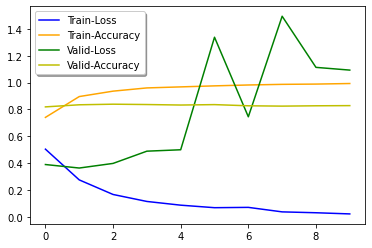

In [ ]:
results_bilstm = model_bilstm.fit(X, Y, epochs=10, shuffle=True, validation_split=0.2, batch_size=64)
VisRes(results_bilstm)

Epoch 1/10
100/100 [==============================] - 4s 39ms/step - loss: 1.6519 - accuracy: 0.7019 - val_loss: 0.9434 - val_accuracy: 0.8031
Epoch 2/10
100/100 [==============================] - 3s 34ms/step - loss: 0.6077 - accuracy: 0.8661 - val_loss: 0.5181 - val_accuracy: 0.8319
Epoch 3/10
100/100 [==============================] - 3s 34ms/step - loss: 0.3411 - accuracy: 0.9114 - val_loss: 0.4590 - val_accuracy: 0.8344
Epoch 4/10
100/100 [==============================] - 4s 35ms/step - loss: 0.2575 - accuracy: 0.9308 - val_loss: 0.4957 - val_accuracy: 0.8300
Epoch 5/10
100/100 [==============================] - 3s 33ms/step - loss: 0.2070 - accuracy: 0.9459 - val_loss: 0.4980 - val_accuracy: 0.8425
Epoch 6/10
100/100 [==============================] - 3s 34ms/step - loss: 0.1683 - accuracy: 0.9573 - val_loss: 0.4962 - val_accuracy: 0.8238
Epoch 7/10
100/100 [==============================] - 3s 34ms/step - loss: 0.1454 - accuracy: 0.9598 - val_loss: 0.4347 - val_accuracy: 0.8331

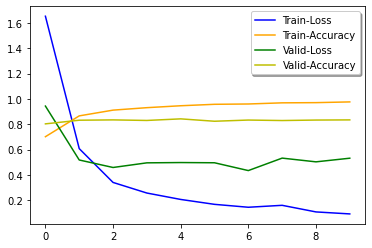

In [ ]:
# BiLSTM _test1
np.random.seed(0)
set_seed(0)
model_bilstm = Sequential()
model_bilstm.add(Embedding(vocab_size, 100, input_length=max_length))
model_bilstm.add(Dropout(0.5))
forward_layer = LSTM(128, return_sequences=True,kernel_regularizer=regularizers.l2(0.001),kernel_initializer='he_uniform')
backward_layer = LSTM(128, activation='relu', return_sequences=True, go_backwards=True,kernel_regularizer=regularizers.l2(0.001),kernel_initializer='he_uniform')
model_bilstm.add(Bidirectional(forward_layer, backward_layer=backward_layer, input_shape=(5, 10)))
model_bilstm.add(Dropout(0.4))
model_bilstm.add(Flatten())
model_bilstm.add(Dense(64, activation='relu'))
model_bilstm.add(Dropout(0.5))
model_bilstm.add(Dense(2, activation='sigmoid'))
model_bilstm.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])
results_bilstm_1 = model_bilstm.fit(X, Y, epochs=10, shuffle=True, validation_split=0.2, batch_size=64)
VisRes(results_bilstm_1)

Epoch 1/20
100/100 [==============================] - 4s 43ms/step - loss: 2.1071 - accuracy: 0.7494 - val_loss: 1.6929 - val_accuracy: 0.7837
Epoch 2/20
100/100 [==============================] - 4s 38ms/step - loss: 1.4292 - accuracy: 0.7942 - val_loss: 1.1792 - val_accuracy: 0.8062
Epoch 3/20
100/100 [==============================] - 4s 38ms/step - loss: 1.0289 - accuracy: 0.8094 - val_loss: 0.8557 - val_accuracy: 0.8294
Epoch 4/20
100/100 [==============================] - 4s 37ms/step - loss: 0.7775 - accuracy: 0.8244 - val_loss: 0.7680 - val_accuracy: 0.7906
Epoch 5/20
100/100 [==============================] - 4s 38ms/step - loss: 0.6562 - accuracy: 0.8223 - val_loss: 0.6648 - val_accuracy: 0.7962
Epoch 6/20
100/100 [==============================] - 4s 39ms/step - loss: 0.5724 - accuracy: 0.8327 - val_loss: 0.5935 - val_accuracy: 0.8119
Epoch 7/20
100/100 [==============================] - 4s 38ms/step - loss: 0.5241 - accuracy: 0.8394 - val_loss: 0.5404 - val_accuracy: 0.8125

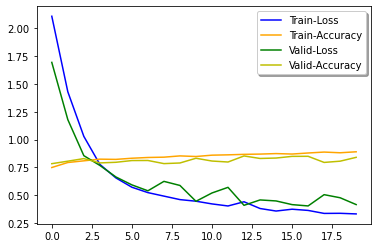

In [ ]:
# Glove + BiLSTM
np.random.seed(0)
set_seed(0)
model_bilstm = Sequential()
model_bilstm.add(Embedding(vocab_size, EMB_DIM, input_length=max_length, weights=[emb_matrix], trainable=True))
model_bilstm.add(Dropout(0.5))
forward_layer = LSTM(128, return_sequences=True,kernel_regularizer=regularizers.l2(0.001),kernel_initializer='he_uniform')
backward_layer = LSTM(128, activation='relu', return_sequences=True, go_backwards=True, kernel_regularizer=regularizers.l2(0.001),kernel_initializer='he_uniform')
model_bilstm.add(Bidirectional(forward_layer, backward_layer=backward_layer, input_shape=(5, 10)))
model_bilstm.add(Dropout(0.4))
model_bilstm.add(Flatten())
# model_bilstm.add(Dense(64, activation='relu'))
# model_bilstm.add(Dropout(0.2))
model_bilstm.add(Dense(2, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001),kernel_initializer='he_uniform'))
model_bilstm.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])
results_bilstm_glove = model_bilstm.fit(X, Y, epochs=20, shuffle=True, validation_split=0.2, batch_size=64)
VisRes(results_bilstm_glove)

Epoch 1/37
100/100 [==============================] - 5s 47ms/step - loss: 0.8073 - accuracy: 0.6936 - val_loss: 0.6837 - val_accuracy: 0.7681
Epoch 2/37
100/100 [==============================] - 4s 41ms/step - loss: 0.6861 - accuracy: 0.7588 - val_loss: 0.5931 - val_accuracy: 0.8075
Epoch 3/37
100/100 [==============================] - 4s 41ms/step - loss: 0.6233 - accuracy: 0.7834 - val_loss: 0.5477 - val_accuracy: 0.8156
Epoch 4/37
100/100 [==============================] - 4s 41ms/step - loss: 0.5730 - accuracy: 0.7933 - val_loss: 0.5145 - val_accuracy: 0.8194
Epoch 5/37
100/100 [==============================] - 4s 41ms/step - loss: 0.5448 - accuracy: 0.8044 - val_loss: 0.4937 - val_accuracy: 0.8219
Epoch 6/37
100/100 [==============================] - 4s 41ms/step - loss: 0.5088 - accuracy: 0.8102 - val_loss: 0.4550 - val_accuracy: 0.8356
Epoch 7/37
100/100 [==============================] - 4s 40ms/step - loss: 0.4838 - accuracy: 0.8227 - val_loss: 0.4323 - val_accuracy: 0.8450

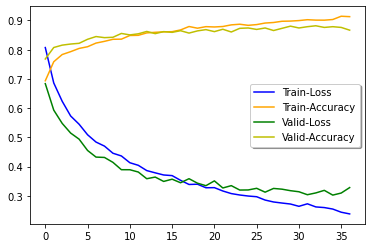

In [ ]:
# Glove + BiLSTM
np.random.seed(0)
set_seed(0)
model_bilstm = Sequential()
model_bilstm.add(Embedding(vocab_size, EMB_DIM, input_length=max_length, weights=[emb_matrix], trainable=True))
model_bilstm.add(Dropout(0.5))
forward_layer = LSTM(16, return_sequences=True,kernel_regularizer=regularizers.l2(0.001),kernel_initializer='he_uniform')
backward_layer = LSTM(16, activation='relu', return_sequences=True, go_backwards=True, kernel_regularizer=regularizers.l2(0.001),kernel_initializer='he_uniform')
model_bilstm.add(Bidirectional(forward_layer, backward_layer=backward_layer, input_shape=(5, 10)))
model_bilstm.add(Dropout(0.2))
model_bilstm.add(Flatten())
model_bilstm.add(Dense(16, activation='relu'))
model_bilstm.add(Dropout(0.1))
model_bilstm.add(Dense(2, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001),kernel_initializer='he_uniform'))
model_bilstm.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])
results_bilstm_glove = model_bilstm.fit(X, Y, epochs=35, shuffle=True, validation_split=0.2, batch_size=64)
VisRes(results_bilstm_glove)

In [ ]:
model_bilstm.save('./models/bilstm_g25-fc16-35epo-fc16-quick.h5')

Epoch 1/23
100/100 [==============================] - 5s 53ms/step - loss: 0.9234 - accuracy: 0.7359 - val_loss: 0.7099 - val_accuracy: 0.8181
Epoch 2/23
100/100 [==============================] - 5s 48ms/step - loss: 0.7076 - accuracy: 0.7981 - val_loss: 0.5932 - val_accuracy: 0.8375
Epoch 3/23
100/100 [==============================] - 5s 47ms/step - loss: 0.5967 - accuracy: 0.8289 - val_loss: 0.5101 - val_accuracy: 0.8525
Epoch 4/23
100/100 [==============================] - 5s 48ms/step - loss: 0.5227 - accuracy: 0.8425 - val_loss: 0.4551 - val_accuracy: 0.8669
Epoch 5/23
100/100 [==============================] - 5s 48ms/step - loss: 0.4692 - accuracy: 0.8569 - val_loss: 0.4287 - val_accuracy: 0.8656
Epoch 6/23
100/100 [==============================] - 5s 48ms/step - loss: 0.4378 - accuracy: 0.8616 - val_loss: 0.3941 - val_accuracy: 0.8731
Epoch 7/23
100/100 [==============================] - 5s 48ms/step - loss: 0.4007 - accuracy: 0.8694 - val_loss: 0.3937 - val_accuracy: 0.8694

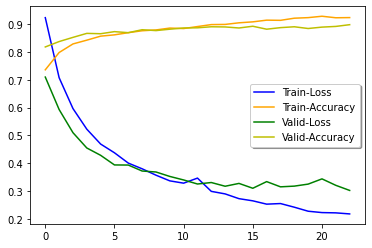

In [ ]:
# Glove + BiLSTM
np.random.seed(1)
set_seed(2)
model_bilstm = Sequential()
model_bilstm.add(Embedding(vocab_size, EMB_DIM, input_length=max_length, weights=[emb_matrix], trainable=True))
model_bilstm.add(Dropout(0.5))
forward_layer = LSTM(32, return_sequences=True,kernel_regularizer=regularizers.l2(0.001),kernel_initializer='he_uniform')
backward_layer = LSTM(32, activation='relu', return_sequences=True, go_backwards=True, kernel_regularizer=regularizers.l2(0.001),kernel_initializer='he_uniform')
model_bilstm.add(Bidirectional(forward_layer, backward_layer=backward_layer, input_shape=(5, 10)))
model_bilstm.add(Dropout(0.2))
model_bilstm.add(Flatten())
model_bilstm.add(Dense(16, activation='relu'))
model_bilstm.add(Dropout(0.1))
model_bilstm.add(Dense(2, activation='sigmoid'))
model_bilstm.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])
results_bilstm_glove = model_bilstm.fit(X, Y, epochs=23, shuffle=True, validation_split=0.2, batch_size=64)
VisRes(results_bilstm_glove)

## CNN1d


Epoch 1/30
100/100 [==============================] - 1s 6ms/step - loss: 0.7032 - accuracy: 0.6192 - val_loss: 0.6955 - val_accuracy: 0.6194
Epoch 2/30
100/100 [==============================] - 0s 5ms/step - loss: 0.6072 - accuracy: 0.6928 - val_loss: 0.5382 - val_accuracy: 0.8075
Epoch 3/30
100/100 [==============================] - 0s 5ms/step - loss: 0.4180 - accuracy: 0.8381 - val_loss: 0.4452 - val_accuracy: 0.8206
Epoch 4/30
100/100 [==============================] - 0s 5ms/step - loss: 0.3276 - accuracy: 0.8855 - val_loss: 0.4186 - val_accuracy: 0.8300
Epoch 5/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2786 - accuracy: 0.9078 - val_loss: 0.4113 - val_accuracy: 0.8388
Epoch 6/30
100/100 [==============================] - 0s 5ms/step - loss: 0.2374 - accuracy: 0.9287 - val_loss: 0.3949 - val_accuracy: 0.8462
Epoch 7/30
100/100 [==============================] - 0s 5ms/step - loss: 0.2112 - accuracy: 0.9373 - val_loss: 0.4103 - val_accuracy: 0.8375
Epoch 

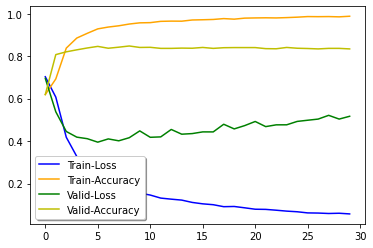

In [ ]:
def model_cnn():
  model = Sequential()
  model.add(Embedding(vocab_size, 50, input_length=max_length))
  model.add(Dropout(0.5))
  model.add(Conv1D(16, 3, padding='valid', activation='relu', strides=1,kernel_regularizer=regularizers.l2(0.001),kernel_initializer='he_uniform'))
  model.add(Dropout(0.2))

  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  
  # model.add(GlobalMaxPooling1D())
  model.add(Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.001),kernel_initializer='he_uniform'))
  model.add(Dropout(0.1))

  model.add(Dense(2, activation='sigmoid'))
  model.compile(loss = "binary_crossentropy",  #sparse_categorical_crossentropy
              optimizer = 'rmsprop',
              metrics = ['accuracy'])
  return model
model_cnn = model_cnn()
results_cnn_glove = model_cnn.fit(X, Y, epochs=30, shuffle=True, validation_split=0.2, batch_size=64)
VisRes(results_cnn_glove)

# DEV set

In [ ]:
dev = pd.read_csv("public_dev.csv")
dev.loc[:,'tokens'] = [processText(t, rmStop=True) for t in dev.text]
dev.loc[:,'token_len'] = [len(t) for t in dev.tokens]
dev

,id,text,tokens,token_len
0,8001,What's the difference between a Bernie Sanders...,"['s, difference, bernie, sanders, supporter, f...",13
1,8002,"Vodka, whisky, tequila. I'm calling the shots.","[vodka, whisky, tequila, 'm, calling, shots]",6
2,8003,French people don't masturbate They Jacque off,"[french, people, n't, masturbate, jacque]",5
3,8004,A lot of Suicide bombers are Muslims - I don't...,"[lot, suicide, bombers, muslims, -, n't, blame...",11
4,8005,What happens when you fingerbang a gypsy on he...,"[happens, fingerbang, gypsy, period, ?, get, p...",8
...,...,...,...,...
995,8996,boss: what are you doing inventor of the bagpi...,"[boss, :, inventor, bagpipes, :, no, fucking, ...",8
996,8997,I told him his views were pretty extreme and i...,"[told, views, pretty, extreme, would, benefici...",12
997,8998,"""Mum, all the black kids call each other Nigga...","[``, mum, black, kids, call, nigga, call, get,...",16
998,8999,"In honor of Fathers Day, I'm gonna bring you ""...","[honor, fathers, day, 'm, gon, na, bring, ``, ...",40


In [ ]:
X_dev, vocab_size_dev, max_length_dev = encodeText(dev['tokens'], max_len=max_length)
X_dev.shape, vocab_size_dev, max_length_dev

((1000, 68), 14766, 68)

In [ ]:
# task 1a
y_pred = model.predict(X_dev)
y_pred = [np.argmax(i) for i in y_pred]
pd.Series(y_pred).value_counts() #lstm2 输出不加:640/625/638  outputl2: 614/645/637/629

1    625
0    375
dtype: int64

In [ ]:
# temp = pd.DataFrame(y_pred)
# temp[3] = temp[1] - temp[0]
# top500_index = list(temp[temp[3]>0][3].sort_values(ascending=False).index[:500])
# output.loc[top500_index,'edit'] = 1
# output = output.fillna(0)
# new_output = output.iloc[:,[0,2]]
# new_output = new_output.rename(columns={'edit':'is_humor'})
# new_output.is_humor = new_output.is_humor.astype(int)

# # new_output
# compression_opts = dict(method='zip', archive_name='res.csv')  
# new_output.to_csv('zehao_liu_lstm2_g50_t1aBanlanced.zip', index=None, compression=compression_opts)

In [ ]:
y_pred = model_bilstm.predict(X_dev)
y_pred = [np.argmax(i) for i in y_pred]
pd.Series(y_pred).value_counts() #652/657

1    652
0    348
dtype: int64

In [ ]:
# task 1b
y_pred_rating = np.ravel(model_1b.predict(X_dev))
y_pred_rating = minMaxScaler(y_pred_rating,min=0.1,max=5)
# y_pred_rating = [round(i*5,7) for i in y_pred_rating]

In [ ]:
# task 1c
y_pred_1c = model_1c.predict(X_dev)
y_pred_1c = [np.argmax(i) for i in y_pred_1c]
pd.Series(y_pred_1c).value_counts()

0    619
1    381
dtype: int64

In [ ]:
output.loc[:,'humor_controversy'] = y_pred_1c
output

In [ ]:
# task 2
y_pred_2 = model_2.predict(X_dev)
y_pred_2 = minMaxScaler(y_pred_2,min=0,max=5)
output.loc[:,'offense_rating'] = y_pred_2
output

,id,is_humor,humor_rating,humor_controversy,offense_rating
0,8001,1,1.378559,1,4.300557
1,8002,1,0.162635,1,2.101319
2,8003,1,1.808180,0,2.986577
3,8004,1,0.509851,0,3.901217
4,8005,1,1.405678,0,1.563737
...,...,...,...,...,...
995,8996,1,2.212317,1,1.492277
996,8997,0,0.000000,0,0.388776
997,8998,1,1.603107,1,4.341868
998,8999,1,2.454719,0,0.253723


(array([ 9.,  8., 14., 35., 38., 36., 44., 39., 31., 39., 32., 39., 39.,
        42., 22., 29., 30., 28., 34., 24., 23., 15.,  7., 11., 22.,  9.,
        18., 13.,  8., 10.,  3.,  8.,  5.,  6.,  6.,  3.,  3.,  4.,  7.,
         6.,  9.,  4.,  7.,  3.,  4.,  7.,  3.,  6.,  7.,  2.,  8.,  5.,
         8.,  2.,  8.,  3.,  4.,  4.,  6.,  4.,  4.,  5.,  2.,  4.,  2.,
         3.,  5.,  1.,  4.,  5.,  2.,  4.,  5.,  2.,  1.,  4.,  2.,  3.,
         1.,  5.,  0.,  3.,  3.,  3.,  3.,  1.,  5.,  2.,  1.,  2.,  3.,
         2.,  0.,  2.,  0.,  0.,  1.,  0.,  0.,  2.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
        1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 ,
        1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05, 2.1 , 2.15,
        2.2 , 2.25, 2.3 , 2.35, 2.4 , 2.45, 2.5 , 2.55, 2.6 , 2.65, 2.7 ,
        2.75, 2.8 , 2.85, 2.9 , 2.95, 3.  , 3.05, 3.1 , 3.15, 3.

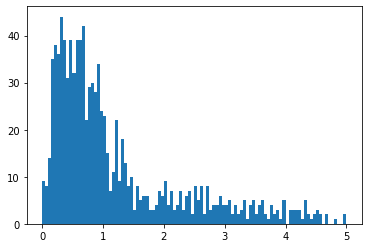

In [ ]:
plt.hist(y_pred_2, bins=100)

(array([27., 10.,  8.,  4.,  9.,  5.,  5.,  5.,  7.,  2.,  4.,  6.,  4.,
         5.,  7., 12.,  4.,  8.,  9.,  8.,  4.,  4., 16., 11.,  9., 10.,
        13., 12.,  8., 24., 15.,  8., 14., 10., 14., 10., 14., 15., 20.,
         9., 13., 20., 15., 23., 17., 21., 16., 16., 10., 17., 26., 15.,
        21., 17., 17., 24., 21., 23., 16., 15., 12., 11., 13.,  7., 18.,
         9.,  8., 17., 14., 13., 11., 13., 11.,  8., 13.,  9.,  9.,  8.,
        10.,  6.,  1.,  3.,  3.,  3.,  4.,  0.,  6.,  0.,  0.,  1.,  1.,
         1.,  0.,  1.,  0.,  2.,  1.,  0.,  0.,  1.]),
 array([0.1  , 0.149, 0.198, 0.247, 0.296, 0.345, 0.394, 0.443, 0.492,
        0.541, 0.59 , 0.639, 0.688, 0.737, 0.786, 0.835, 0.884, 0.933,
        0.982, 1.031, 1.08 , 1.129, 1.178, 1.227, 1.276, 1.325, 1.374,
        1.423, 1.472, 1.521, 1.57 , 1.619, 1.668, 1.717, 1.766, 1.815,
        1.864, 1.913, 1.962, 2.011, 2.06 , 2.109, 2.158, 2.207, 2.256,
        2.305, 2.354, 2.403, 2.452, 2.501, 2.55 , 2.599, 2.648, 2.697,
        

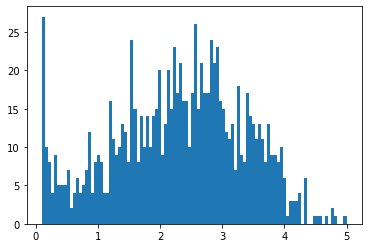

In [ ]:
plt.hist(y_pred_rating,bins=100)

In [ ]:
# output = pd.DataFrame(dev.loc[:,'id'])
# output.loc[:,'is_humor'] = y_pred
output = res.copy()
output.loc[:,'humor_rating'] = y_pred_rating

output.loc[list(output[output.is_humor==0].index),'humor_rating']=0

(array([16.,  8.,  4.,  6.,  2.,  6.,  2.,  3.,  5.,  1.,  5.,  4.,  0.,
         5.,  3.,  3.,  7.,  3.,  4.,  7.,  3.,  1.,  4.,  8.,  7.,  7.,
         7.,  6.,  9.,  3., 13., 12.,  7.,  7.,  5.,  7.,  3.,  9.,  9.,
        12.,  9., 10.,  8.,  9., 15., 13., 11.,  6.,  9., 10.,  5.,  8.,
        10., 10., 12.,  8., 11., 13.,  9., 11., 10.,  8.,  5.,  8.,  6.,
         3.,  8.,  6.,  5., 11.,  8., 12.,  4.,  6.,  8.,  5.,  5.,  7.,
         6.,  4.,  5.,  8.,  4.,  1.,  2.,  2.,  2.,  2.,  0.,  4.,  0.,
         0.,  0.,  0.,  2.,  0.,  0.,  0.,  2.,  1.]),
 array([0.1       , 0.1473304 , 0.19466079, 0.24199119, 0.28932159,
        0.33665198, 0.38398238, 0.43131278, 0.47864318, 0.52597357,
        0.57330397, 0.62063437, 0.66796476, 0.71529516, 0.76262556,
        0.80995595, 0.85728635, 0.90461675, 0.95194714, 0.99927754,
        1.04660794, 1.09393833, 1.14126873, 1.18859913, 1.23592953,
        1.28325992, 1.33059032, 1.37792072, 1.42525111, 1.47258151,
        1.51991191, 1.5672

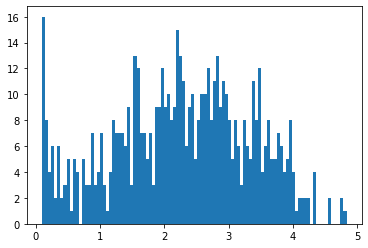

In [ ]:
plt.hist(output[output['is_humor']==1]['humor_rating'],bins=100)

In [ ]:
compression_opts = dict(method='zip', archive_name='res.csv')  
output.to_csv('zehao_liu_dev26_lstm_g50_BestTaskAll.zip', index=None, compression=compression_opts)


In [ ]:
output = pd.DataFrame(dev.loc[:,'id'])
output.loc[:,'is_humor'] = y_pred
output.loc[:,'humor_rating'] = y_pred_rating
compression_opts = dict(method='zip', archive_name='res.csv')  
output.to_csv('zehao_liu_dev23_lstm_g50_quick_4_rmisalpha.zip', index=None, compression=compression_opts)
# output.to_csv('zehao_res.gz', compression='gzip')

In [ ]:
## Bert
# https://keras.io/examples/nlp/text_extraction_with_bert/
# https://zhuanlan.zhihu.com/p/46652512
# https://zhuanlan.zhihu.com/p/51413773